# Capstone Notebook

# Stakeholder and Business Problem

This project is intended to provide the Minnesota Department of Transportation (MNDOT) with information and recommendations about what factors lead to heavy traffic volume and if anything can be done along I-94 to mitigate these factors. The dataset was pulled from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#).

In [623]:
# Import tools and libraries
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1)

# try:
    # %load_ext autotime
# except:
    # !pip install ipython-autotime
    # %load_ext autotime
    
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 15 ms (started: 2023-04-06 17:19:24 -06:00)


In [624]:
# Read in traffic data
df = pd.read_csv('data\Metro_Interstate_Traffic_Volume.csv')
df_noaa = pd.read_csv('data/noaa_data.csv')

time: 78 ms (started: 2023-04-06 17:19:24 -06:00)


In [625]:
# Previewing data
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


time: 0 ns (started: 2023-04-06 17:19:24 -06:00)


Per the UCI website that hosts the data, the feature descriptions are as follows:

holiday: Categorical US National holidays plus regional holiday, Minnesota State Fair<br>
temp: Numeric Average temp in kelvin<br>
rain_1h: Numeric Amount in mm of rain that occurred in the hour<br>
snow_1h: Numeric Amount in mm of snow that occurred in the hour<br>
clouds_all: Numeric Percentage of cloud cover<br>
weather_main: Categorical Short textual description of the current weather<br>
weather_description: Categorical Longer textual description of the current weather<br>
date_time: DateTime Hour of the data collected in local CST time<br>
traffic_volume: Numeric Hourly I-94 ATR 301 reported westbound traffic volume<br>

Let's take a look at the first variable in our dataset, *temp*.

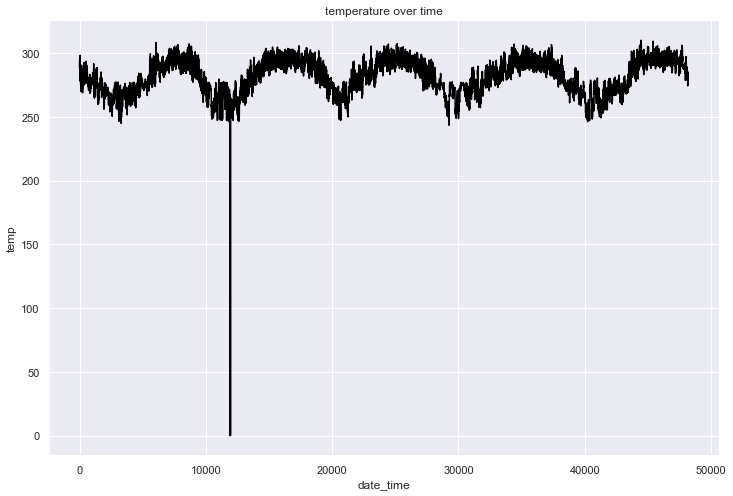

time: 219 ms (started: 2023-04-06 17:19:24 -06:00)


In [626]:
# Plotting temperature over time for entire dataset
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black")

ax.set_xlabel('date_time');
ax.set_ylabel('temp')
ax.set_title('temperature over time');

It appears that the temperature follows an expected seasonal pattern except for a smattering of values that are listed as zero. Let's explore where those values are.

In [627]:
# Viewing zero values for the 'temp' column
df_date[df_date['temp'] == 0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,


time: 0 ns (started: 2023-04-06 17:19:24 -06:00)


There are two days in early 2014 that have a few hours with the temperature listed at zero. We know that the 'temp' column is listed in units of Kelvin; zero degrees Kelvin is the lowest limit of the thermodynamic temperature scale where atoms/particles stop moving so it is safe to assume this data is not accurate.

To fix this, we'll take a look at the recorded temperatures immediately before and after the inaccurate temperature data and fill them in with the average value.

In [628]:
# Viewing temperature values immediately before and after the inaccurate data
df['temp'].loc[11897:11902], df['temp'].loc[11945:11952]

(11897    255.93
 11898      0.00
 11899      0.00
 11900      0.00
 11901      0.00
 11902    255.93
 Name: temp, dtype: float64,
 11945    255.37
 11946      0.00
 11947      0.00
 11948      0.00
 11949      0.00
 11950      0.00
 11951      0.00
 11952    255.62
 Name: temp, dtype: float64)

time: 0 ns (started: 2023-04-06 17:19:24 -06:00)


In [629]:
# Setting inaccurate values to be equal to the average of the values immediately before and after
df['temp'].loc[11898:11901] = (df['temp'].loc[11897] + df['temp'].loc[11902]) / 2
df['temp'].loc[11946:11951] = (df['temp'].loc[11945] + df['temp'].loc[11952]) / 2

time: 0 ns (started: 2023-04-06 17:19:24 -06:00)


C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


11897    255.93
11898    255.93
11899    255.93
11900    255.93
11901    255.93
11902    255.93
Name: temp, dtype: float64 11944    255.480
11945    255.370
11946    255.495
11947    255.495
11948    255.495
11949    255.495
11950    255.495
11951    255.495
11952    255.620
Name: temp, dtype: float64


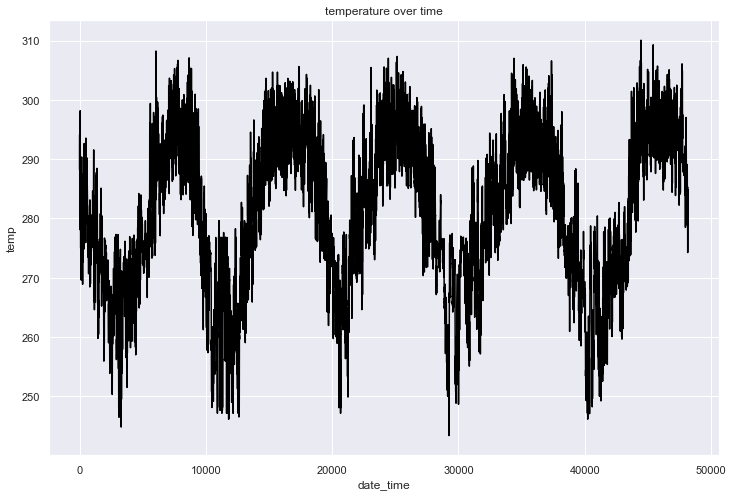

time: 250 ms (started: 2023-04-06 17:19:24 -06:00)


In [630]:
# Checking results
print(df['temp'].loc[11897:11902], df['temp'].loc[11944:11952])

# Plotting again for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black", label='Temp')

ax.set_xlabel('date_time')
ax.set_ylabel('temp')
ax.set_title('temperature over time');

The plot looks better now that we've filled in the zero values for the temperature data. It follows the expected seasonal trend of decreasing temperatures as winter approaches and increasing temperatures as summer approaches. Next let's visually inspect the other numeric variables in the dataset: *rain_1h*, *snow_1h*, *clouds_all*, and *traffic_volume*.

Text(0.5, 1.0, 'traffic_volume')

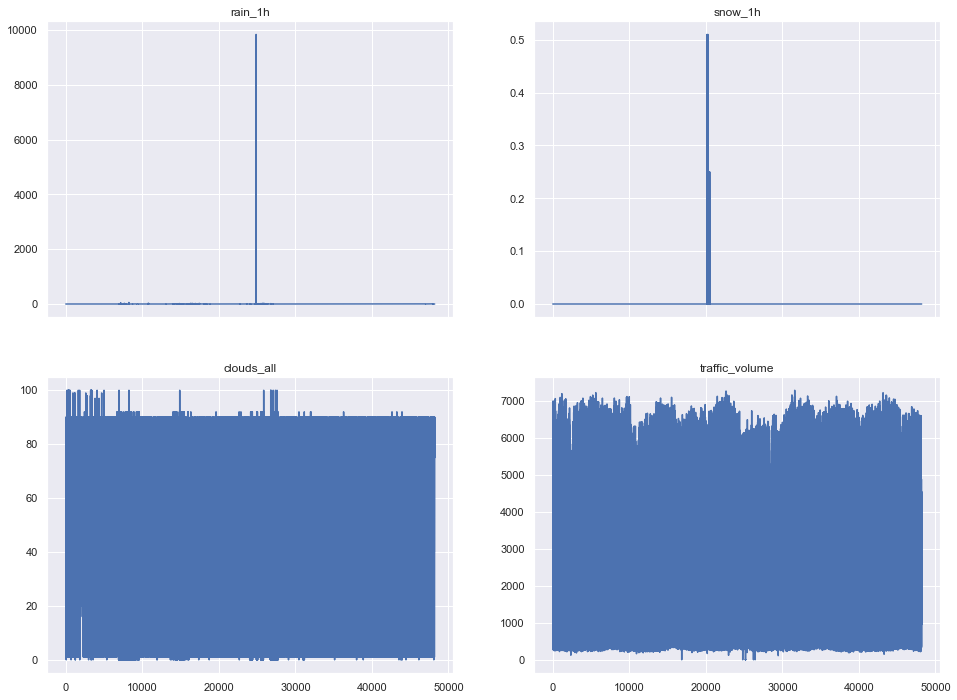

time: 891 ms (started: 2023-04-06 17:19:24 -06:00)


In [631]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df['rain_1h']); axes[0, 0].set_title('rain_1h')
axes[0, 1].plot(df['snow_1h']); axes[0, 1].set_title('snow_1h')
axes[1, 0].plot(df['clouds_all']); axes[1, 0].set_title('clouds_all')
axes[1, 1].plot(df['traffic_volume']); axes[1, 1].set_title('traffic_volume')

*clouds_all* and *traffic_volume* appear to have normal values across the dataset but there are some odd looking spikes in the data for *rain_1h* and *snow_1h*. Both of these are measured in millimeters. It's unlikely that a singular day or hour produced almost 10,000 mm of rain and the snow values are suspiciously low for a state as far North as Minnesota.

To fix this, I obtained a dataset compiled by the [National Oceanic and Atmospheric Administration (NOAA)](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014922/detail). The dataset provides daily weather data gathered by a weather station at the Minneapolis St. Paul International Airport and can be used to cross-reference the UCI dataset.

In [632]:
# Top 10 hourly rainfall values
df.sort_values(by='rain_1h', ascending=False).head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24872,None,302.11,9831.30,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535
8247,None,289.10,55.63,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315
7179,None,295.82,44.45,0.0,76,Rain,very heavy rain,2013-06-24 11:00:00,4802
25779,None,297.71,31.75,0.0,0,Rain,very heavy rain,2016-08-16 17:00:00,4913
10807,None,264.50,28.70,0.0,64,Snow,light snow,2013-12-19 23:00:00,1190


time: 16 ms (started: 2023-04-06 17:19:25 -06:00)


In [633]:
# Totalling snowfall values across entire dataset
df['snow_1h'].sum()

10.72

time: 16 ms (started: 2023-04-06 17:19:25 -06:00)


It's highly unlikely that 9,831 mm (approximately 32 feet!) of rain fell in one hour. It's also extremely unlikely that the total amount of snowfall listed across the entire dataset is 10.72 mm (0.42 inches). To fix this, we'll make some changes to the *date_time* column and the overall dataframe until we have a daily time series with complete and sensible values.

In [634]:
# Converting date_time column from object to datetime
df['date_time'] = pd.to_datetime(df['date_time'], infer_datetime_format=True)

# Extracting various date and time values from date_time column
df['date'] = df['date_time'].dt.date
df['year'] = df['date_time'].dt.year
df['month_day'] = df['date_time'].dt.strftime('%m-%d')
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['weekday'] = df['date_time'].dt.day_name()
df['hour'] = df['date_time'].dt.hour

# Converting newly created date column from object to datetime
df['date'] = pd.to_datetime(df['date'])

time: 469 ms (started: 2023-04-06 17:19:25 -06:00)


In [635]:
# Converting temp column to Fahrenheit values and rain/snow measurements to inches
df['temp'] = (df['temp'] - 273.15) * 9/5 + 32
df['rain_1h'] = df['rain_1h'] * 0.03937
df['snow_1h'] = df['snow_1h'] * 0.03937

# Renaming columns to show units of measurement
df = df.rename(columns={'rain_1h':'rain_in',
                        'snow_1h':'snow_in',
                        'clouds_all':'pct_cloud_cover'})

time: 15 ms (started: 2023-04-06 17:19:26 -06:00)


In [636]:
# Checking results
df.head()

,holiday,temp,rain_in,snow_in,pct_cloud_cover,weather_main,weather_description,date_time,traffic_volume,date,year,month_day,month,day,weekday,hour
0,None,59.234,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02,2012,10-02,10,2,Tuesday,9
1,None,61.178,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02,2012,10-02,10,2,Tuesday,10
2,None,61.574,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02,2012,10-02,10,2,Tuesday,11
3,None,62.564,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02,2012,10-02,10,2,Tuesday,12
4,None,64.382,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02,2012,10-02,10,2,Tuesday,13


time: 16 ms (started: 2023-04-06 17:19:26 -06:00)


Our dataframe now contains values in Imperial units and we've broken the *date_time* column out into separate components. The next step is to set *date_time* as the index of our dataframe so we can resample to daily values.

In [637]:
# Setting date_time as index
df.set_index('date_time', inplace=True)

time: 0 ns (started: 2023-04-06 17:19:26 -06:00)


In [638]:
# Resampling to daily values
df_daily = df.resample('D').agg({'temp':'mean',
                                 'rain_in':'sum',
                                 'snow_in':'sum',
                                 'pct_cloud_cover':'mean',
                                 'traffic_volume':'sum',
                                 'holiday':'last',
                                 'year':'last',
                                 'month_day':'last',
                                 'month':'last',
                                 'day':'last',
                                 'weekday':'last'})

time: 47 ms (started: 2023-04-06 17:19:26 -06:00)


In [639]:
# Checking results
df_daily.head()

,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday
date_time,,,,,,,,,,,
2012-10-02,63.056000,0.0,0.0,29.133333,63289,None,2012.0,10-02,10.0,2.0,Tuesday
2012-10-03,55.874300,0.0,0.0,3.850000,66345,None,2012.0,10-03,10.0,3.0,Wednesday
2012-10-04,61.173500,0.0,0.0,16.708333,89939,None,2012.0,10-04,10.0,4.0,Thursday
2012-10-05,48.070727,0.0,0.0,75.000000,93336,None,2012.0,10-05,10.0,5.0,Friday
2012-10-06,40.272957,0.0,0.0,61.652174,74910,None,2012.0,10-06,10.0,6.0,Saturday


time: 15 ms (started: 2023-04-06 17:19:26 -06:00)


We now have a dataframe with the date as our index and average values for *temp* and *pct_cloud_cover* and totals for *rain_in*, *snow_in*, and *traffic_volume*. Let's take a look at some of these graphically.

Text(0.5, 1.0, 'traffic_volume')

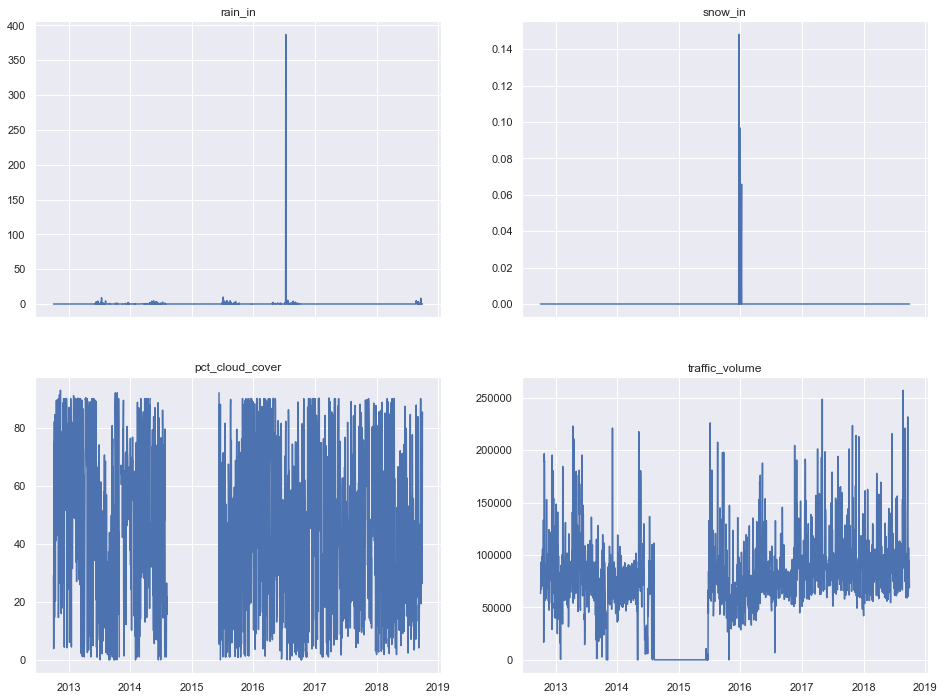

time: 750 ms (started: 2023-04-06 17:19:26 -06:00)


In [640]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df_daily['rain_in']); axes[0, 0].set_title('rain_in')
axes[0, 1].plot(df_daily['snow_in']); axes[0, 1].set_title('snow_in')
axes[1, 0].plot(df_daily['pct_cloud_cover']); axes[1, 0].set_title('pct_cloud_cover')
axes[1, 1].plot(df_daily['traffic_volume']); axes[1, 1].set_title('traffic_volume')

We still have the same oddities in the rain and snow values, but it looks like we're missing a big chunk of data from cloud cover and traffic volume.

In [641]:
# Checking for zero values in traffic_volume
df_daily[df_daily['traffic_volume'] == 0]

,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday
date_time,,,,,,,,,,,
2013-10-28,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-29,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-30,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-31,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-01,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-21,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-23,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-24,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


time: 31 ms (started: 2023-04-06 17:19:27 -06:00)


330 days of zero *traffic_volume* values! That can't be right. To fix this, our best option is to find the average values from the same combinations of month and day that are present in the rest of our dataset. First, let's cast the *year*, *month*, and *day* columns as integers to get rid of those decimals.

In [642]:
df_daily['year'] = df_daily['year'].fillna(0).astype(int)
df_daily['month'] = df_daily['month'].fillna(0).astype(int)
df_daily['day'] = df_daily['day'].fillna(0).astype(int)

time: 15 ms (started: 2023-04-06 17:19:27 -06:00)


In [643]:
# Checking number of rows in df_daily
df_daily.shape

(2190, 11)

time: 0 ns (started: 2023-04-06 17:19:27 -06:00)


In [644]:
# Creating new dataframe with no null values and checking new number of rows
df_daily_no_null = df_daily.dropna()
df_daily_no_null.shape

(1860, 11)

time: 16 ms (started: 2023-04-06 17:19:27 -06:00)


2190 - 330 = 1860. Next we'll group by month and day to find the average *traffic_volume* and *pct_cloud_cover* values for each (non-null) value.

In [645]:
# Group by month and day, calculate the mean, reset index, and check results
df_daily_no_null = df_daily_no_null.groupby(['month_day']).agg({'traffic_volume':'mean',
                                                                   'pct_cloud_cover':'mean'})
df_daily_no_null = df_daily_no_null.reset_index()
df_daily_no_null['traffic_volume'] = df_daily_no_null['traffic_volume'].astype('int')
df_daily_no_null['pct_cloud_cover'] = df_daily_no_null['pct_cloud_cover'].astype('int')

df_daily_no_null.set_index('month_day', drop=False, inplace=True)
df_daily_no_null

,month_day,traffic_volume,pct_cloud_cover
month_day,,,
01-01,01-01,40675,36
01-02,01-02,79661,47
01-03,01-03,92301,60
01-04,01-04,82860,41
01-05,01-05,66190,27
...,...,...,...
12-27,12-27,68401,44
12-28,12-28,90395,62
12-29,12-29,78483,67


time: 31 ms (started: 2023-04-06 17:19:27 -06:00)


In [646]:
df_daily_fix = df_daily.loc['2014-08-08':'2015-06-23']

time: 16 ms (started: 2023-04-06 17:19:27 -06:00)


In [647]:
df_daily_fix

,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday
date_time,,,,,,,,,,,
2014-08-08,67.5770,0.0,0.0,20.5,1364,None,2014,08-08,8,8,Friday
2014-08-09,NaN,0.0,0.0,NaN,0,NaN,0,NaN,0,0,NaN
2014-08-10,NaN,0.0,0.0,NaN,0,NaN,0,NaN,0,0,NaN
2014-08-11,NaN,0.0,0.0,NaN,0,NaN,0,NaN,0,0,NaN
2014-08-12,NaN,0.0,0.0,NaN,0,NaN,0,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-19,78.5426,0.0,0.0,0.0,4681,None,2015,06-19,6,19,Friday
2015-06-20,71.9942,0.0,0.0,88.0,4045,None,2015,06-20,6,20,Saturday
2015-06-21,NaN,0.0,0.0,NaN,0,NaN,0,NaN,0,0,NaN


time: 31 ms (started: 2023-04-06 17:19:27 -06:00)


In [564]:
df_daily['traffic_volume'] = np.where(df_daily['month_day'] == df_daily_no_null['month_day'],
                                      df_daily_no_null['traffic_volume'], df_daily_no_null['traffic_volume'])

ValueError: Can only compare identically-labeled Series objects

time: 0 ns (started: 2023-04-06 16:17:33 -06:00)


In [17]:
df_daily.isna().sum()

traffic_volume    0
dtype: int64

time: 0 ns (started: 2023-04-06 09:06:32 -06:00)


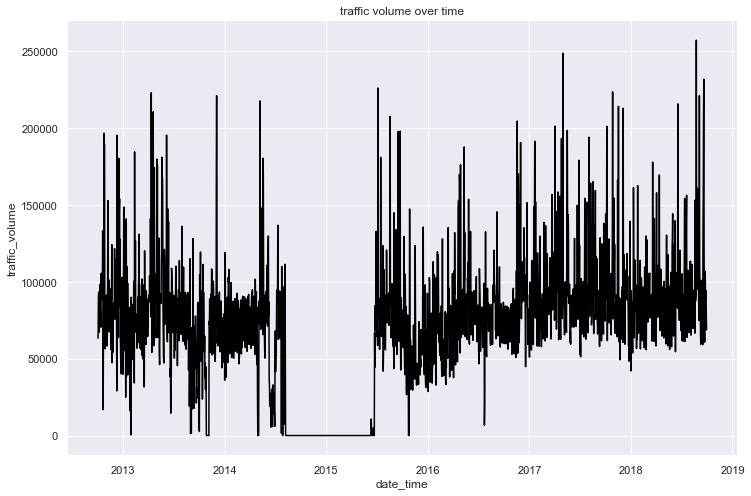

time: 265 ms (started: 2023-04-06 09:06:32 -06:00)


In [18]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily, color = "black")

ax.set_xlabel('date_time')
ax.set_ylabel('traffic_volume')
ax.set_title('traffic volume over time');

## Baseline Model

In [19]:
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error

# Create lagged dataset
values = DataFrame(df_daily.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

       t-1    t+1
0      NaN  63289
1  63289.0  66345
2  66345.0  89939
3  89939.0  93336
4  93336.0  74910
time: 0 ns (started: 2023-04-06 09:06:32 -06:00)


In [20]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.75)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

time: 0 ns (started: 2023-04-06 09:06:32 -06:00)


In [21]:
# persistence model
def model_persistence(x):
 return x

time: 0 ns (started: 2023-04-06 09:06:32 -06:00)


In [22]:
# walk-forward validation
predictions = list()
for x in test_X:
 yhat = model_persistence(x)
 predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 1422240667.569
time: 0 ns (started: 2023-04-06 09:06:32 -06:00)


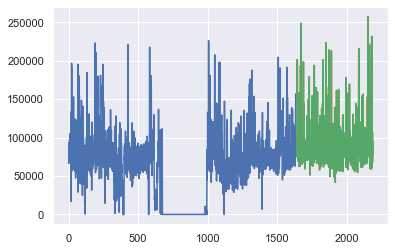

time: 171 ms (started: 2023-04-06 09:06:32 -06:00)


In [23]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()